**File List and Descriptions:**

**article_dates.csv**: File created by Muf and Daniel that contains the dates that the articles were released (some of the dates are in earlier years than 2017 which is likely the original published date and the articles may have seen an update in 2017 which we cannot track)   
**knight_data_ratings.csv**: Contains the ratings for an article given by each user. Also indicates whether the rating was blind or non-blind   
**readers.csv**: Attributes about users who provided the ratings. Age group, gender, political affiliation, etc   
**knight_data_articles.csv**: Contains the article content, title, source and some field derived from the content   
**knight_data_urls.csv**: Contains the article content, title, source URL   


### Imports

In [197]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime

### Helper Functions

In [280]:
def train_test_split_latest(df, date_field='date', test_size=0.2):
    df = df.sort_values(date_field, ascending=False)
    test_count = math.ceil(len(df) * test_size)
    return df[test_count:], df[:test_count]

In [282]:
def get_source_breakup(df, source_field='content_source_desc'):
    source_counts = df.groupby(source_field)['content_id'].count().reset_index()
    source_counts = source_counts.rename({'content_id':'article_counts'}, axis=1)
    source_counts['article_perc'] = source_counts['article_counts']/source_counts['article_counts'].sum()
    return source_counts

In [267]:
def train_test_split_latest_source(df, date_field='date', source_field='content_source_desc', test_size=0.2):
    train_all = pd.DataFrame()
    test_all = pd.DataFrame()
    for source in df[source_field].unique():
        df_source = df[df[source_field]==source]
        train, test = train_test_split_latest(df_source, date_field=date_field, test_size=test_size)
        train_all = train_all.append(train)
        test_all = test_all.append(test)
        
    return train_all, test_all

In [358]:
def train_test_split_source(df, test_source, source_field='content_source_desc', test_size=0.2):
    if test_source not in df[source_field].unique():
        raise ValueError(f"Source must be in {df[source_field].unique()}")
    train = df[df[source_field]!=test_source]
    test = df[df[source_field]==test_source]
    return train, test

### Reading Input Files

In [297]:
article_dates = pd.read_csv('../data/raw/article_dates.csv')
article_dates = article_dates.drop(['Unnamed: 0'], axis=1)
article_dates['date'] = article_dates.apply(lambda x:datetime.date(year=x['year'], month=x['month'], day=x['day']).strftime("%Y-%m-%d"), axis=1)

In [298]:
data_articles = pd.read_csv('../data/raw/knight_data_articles.csv')

In [299]:
article_dates_source = pd.merge(article_dates, data_articles[['content_id', 'content_source_desc', 'content_title_clean', 'content_body_clean']], on='content_id', how='inner')

In [300]:
article_ratings = pd.read_csv('../data/raw/knight_data_ratings.csv')

In [301]:
article_rating_counts = article_ratings.groupby(['content_id', 'blind'])['rating_scale_response'].count().reset_index()

In [302]:
article_rating_counts = article_rating_counts.rename({'rating_scale_response':'rating_counts'}, axis=1)
article_rating_counts['blind'] = article_rating_counts['blind'].map({0:'Non Blind', 1:'Blind'})
article_rating_counts = pd.pivot_table(article_rating_counts, index='content_id', columns='blind').reset_index()
article_rating_counts.columns = ['content_id', 'blind_count', 'non_blind_count']
article_rating_counts = article_rating_counts.fillna(0)

Filtering out only articles that have at least one blind rating

In [303]:
articles_blind = article_rating_counts[article_rating_counts['blind_count']>0]

In [304]:
articles_info = pd.merge(article_dates_source, articles_blind, on='content_id', how='inner')

### Splitting test by selecting the latest articles

In [305]:
train_date, test_date = train_test_split_latest(articles_info, test_size=0.2)

#### Writing out train and test files

In [336]:
train_date.to_csv('../data/temp/sampling/latest/articles_train.csv')
test_date.to_csv('../data/temp/sampling/latest/articles_test.csv')

#### Checking breakup of the datasets by source

In [319]:
train_source = get_source_breakup(train_date)
train_source['type'] = 'train'

In [320]:
test_source = get_source_breakup(test_date)
test_source['type'] = 'test'

In [321]:
overall_source = get_source_breakup(articles_info)
overall_source['type'] = 'overall'

In [322]:
all_source = pd.concat([overall_source, train_source, test_source])

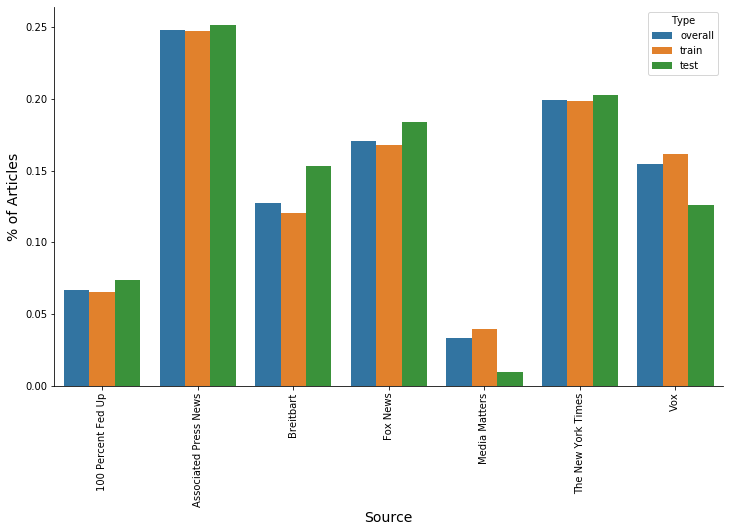

In [323]:
sns.catplot(data=all_source, x='content_source_desc', y='article_perc', hue='type', kind='bar', height=6, aspect=1.7, legend=False)
plt.xticks(rotation=90)
plt.xlabel('Source', fontsize=14)
plt.ylabel('% of Articles', fontsize=14)
plt.legend(title='Type')
plt.show()

### Splitting test by selecting latest within each source

In [324]:
train_date_source, test_date_source = train_test_split_latest_source(articles_info, test_size=0.2)

#### Writing out train and test files

In [343]:
train_date_source.to_csv('../data/temp/sampling/latest_source/articles_train.csv')
test_date_source.to_csv('../data/temp/sampling/latest_source/articles_test.csv')

#### Checking breakup of the datasets by source

In [325]:
train_source = get_source_breakup(train_date_source)
train_source['type'] = 'train'

In [326]:
test_source = get_source_breakup(test_date_source)
test_source['type'] = 'test'

In [327]:
overall_source = get_source_breakup(articles_info)
overall_source['type'] = 'overall'

In [328]:
all_source = pd.concat([overall_source, train_source, test_source])

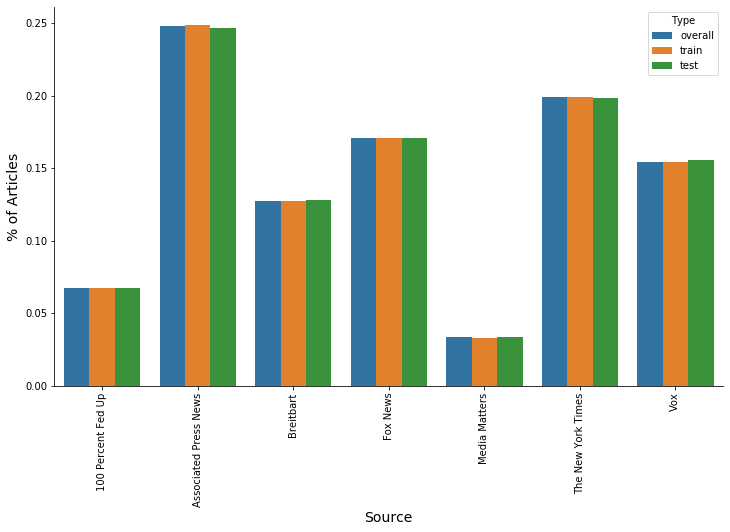

In [329]:
sns.catplot(data=all_source, x='content_source_desc', y='article_perc', hue='type', kind='bar', height=6, aspect=1.7, legend=False)
plt.xticks(rotation=90)
plt.xlabel('Source', fontsize=14)
plt.ylabel('% of Articles', fontsize=14)
plt.legend(title='Type')
plt.show()

### Splitting by Source

#### Writing out train and test files

#### AP

In [359]:
train_src, test_src = train_test_split_source(articles_info, 'Associated Press News')

In [368]:
train_date_source.to_csv('../data/temp/sampling/source/ap/articles_train.csv')
test_date_source.to_csv('../data/temp/sampling/source/ap/rticles_test.csv')

#### NYT

In [380]:
train_src, test_src = train_test_split_source(articles_info, 'The New York Times')

In [383]:
train_date_source.to_csv('../data/temp/sampling/source/nyt/articles_train.csv')
test_date_source.to_csv('../data/temp/sampling/source/nyt/rticles_test.csv')

### General Distribution of articles by source

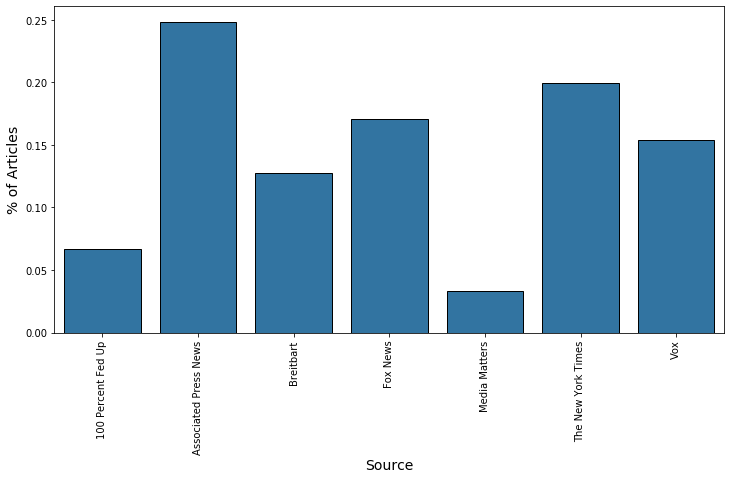

In [366]:
plt.figure(figsize=(12,6))
sns.barplot(data=source_counts, x='content_source_desc', y='article_perc', edgecolor='k', color='#1f77b4')
plt.xticks(rotation=90)
plt.xlabel('Source', fontsize=14)
plt.ylabel('% of Articles', fontsize=14)
plt.show()